In [1]:
import matplotlib.pyplot as plt
plt.rcParams['font.sans-serif'] = ['SimHei']
import numpy as np
import os
import pandas as pd
import time
import keras
from keras.layers.core import Dense, Activation, Dropout
from keras.layers.recurrent import LSTM, GRU
from keras.models import Sequential, load_model
import pandas as pd
from sklearn import metrics 

C:\Users\26755\Anaconda3\lib\site-packages\h5py\__init__.py:34: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.
C:\Users\26755\Anaconda3\lib\site-packages\tensorflow\python\framework\dtypes.py:523: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
C:\Users\26755\Anaconda3\lib\site-packages\tensorflow\python\framework\dtypes.py:524: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
C:\Users\26755\Anaconda3\lib\site-packages\tensorflow\python\framework\

In [7]:
def Data_range(data,range_len):
    data.sort_values('时间')
    Time = data['时间']
    Values = data['容量']
    Values_new = []
    for i in range(0,len(data),range_len):
        values = round(np.mean(Values[i:i+range_len]),2)
        Values_new.append(values)
    return Values_new

#获取时间序列（单步预测，y长度为1）
def generateData(rawData, sequence_length):
    results = list()
    for i in range(len(rawData) - sequence_length):
        results.append(rawData[i:i+sequence_length])
    #分割好的序列（result[0]的长度为20）
    results = np.array(results)
    results_mean = results.mean()
    results = results-results_mean
    
    train_X = results[:,:-1]
    if len(train_X.shape) == 3:
        train_y = results[:,-1,0]
    else:
        train_y = results[:,-1:]
        train_X = np.reshape(train_X, (train_X.shape[0], train_X.shape[1], 1))    

    return train_X, train_y, results_mean

In [3]:
def build_model(input_shape,output_shape,layers):
    model = Sequential()
    
    model.add(LSTM(
            layers[1],
            input_shape=input_shape,
            return_sequences=True))
    model.add(Dropout(0.2))
    
    model.add(LSTM(
            layers[2],
            return_sequences=False))
    model.add(Dropout(0.2))
#     model.add(Activation('softsign'))
    
    model.add(Dense(
            output_shape))
    model.add(Activation("linear"))
#     model.add(Activation('softsign'))
    opt = keras.optimizers.RMSprop(lr=0.001,rho=0.9)
    model.compile(loss="mse", optimizer="rmsprop", metrics=['mae', 'mape'])
    
    return model

In [23]:
def run_network(train_data, test_data,epochs,sequence_length,layers):

    print("Loading data...")
    train_X, train_y, train_mean = generateData(train_data, sequence_length)
    test_X, test_y, test_mean = generateData(test_data, sequence_length)
     
    
    print("\nData loaded.Compiling...")
    input_shape = train_X.shape[-2:]
    output_shape = 1
    model = build_model(input_shape, output_shape,layers)
    
    try:
        model.fit(train_X, train_y, batch_size=200, epochs=epochs,validation_split=0.05,verbose = 1)
#         model.save('disk.h5')
        predicted = model.predict(test_X)
        predicted = np.reshape(predicted, (predicted.size,))
        
    except KeyboardInterrupt:
        return model, y_test, 0
    
    try:
        scores = model.evaluate(test_X, test_y, batch_size=200)
        print("\nevaluate result: \nmse={:.6f}\nmae={:.6f}\nmape={:.6f}".format(scores[0], scores[1], scores[2]))       
        test_y += test_mean
        predicted += test_mean    
    except Exception as e:
        print(str(e))
    return model, test_y, predicted
        

In [20]:
 def result(predicted,train_data,test_data):
        
    plt.plot(test_data, label="真实", alpha=1.0)
    plt.plot(predicted, label="预测", alpha=1.0)
    plt.legend()
    plt.show()    
    
    predicted = pd.Series(list(predicted), index = range(len(train_data),len(train_data)+len(predicted)))
    data =  pd.Series(list(train_data+test_data))
    ax = data.plot(label="真实")
    predicted.plot(ax=ax, label="预测", alpha=1.0)

    ax.set_xlabel(U'时间序号')
    ax.set_ylabel(U'值')
    plt.title("LSTM预测的结果")
    plt.legend()
    plt.show()


    print("误差MSE：",metrics.mean_squared_error(test_data, predicted))
    print("误差RMSE：",np.sqrt(metrics.mean_squared_error(test_data, predicted)))
    print("误差MAE：",metrics.mean_absolute_error(test_data, predicted))
    print("误差MAPE：",(np.mean(np.abs((test_data,predicted)/np.array(test_data))) * 100))

# 磁盘数据分析

Loading data...

Data loaded.Compiling...
10/10 [==============================] - 0s 399us/step

evaluate result: 
mse=0.001463
mae=0.026809
mape=117.755653


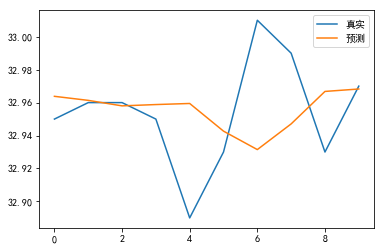

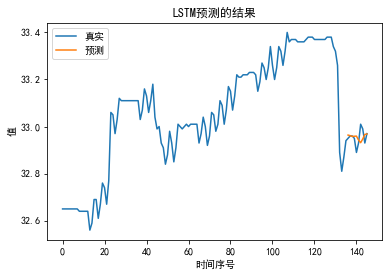

误差MSE： 0.0014625729601876482
误差RMSE： 0.03824360025138387
误差MAE： 0.026808959960936816
误差MAPE： 100.0027500095791
Loading data...

Data loaded.Compiling...
10/10 [==============================] - 0s 299us/step

evaluate result: 
mse=0.000411
mae=0.018791
mape=262.308411


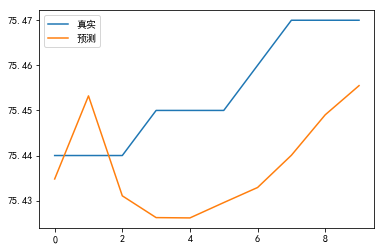

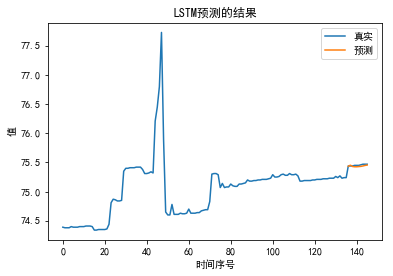

误差MSE： 0.0004113388438615843
误差RMSE： 0.020281490178524465
误差MAE： 0.018791595458984033
误差MAPE： 99.98930107454603


In [21]:
ratio = 20
epochs = 200 
sequence_length=10
model_layers = [1,50,100]

data_d = pd.read_csv('d_buquan_disk.csv')
Values_dnew = Data_range(data_d,36)
train_data = Values_dnew[:len(Values_dnew)-ratio]
test_data = Values_dnew[len(Values_dnew)-ratio:]
model, test_y, predicted=run_network(train_data, test_data, epochs,sequence_length,model_layers)
test_y = test_y.reshape(1,-1).tolist()[0]
result(predicted,train_data,test_y)


data_c = pd.read_csv('c_buquan_disk.csv')
Values_cnew = Data_range(data_c,36)
train_data = Values_cnew[:len(Values_cnew)-ratio]
test_data = Values_cnew[len(Values_cnew)-ratio:]
model, test_y, predicted=run_network(train_data, test_data, epochs,sequence_length,model_layers)
test_y = test_y.reshape(1,-1).tolist()[0]
result(predicted,train_data,test_y)

# Redis命中率分析

Loading data...

Data loaded.Compiling...
10/10 [==============================] - 0s 399us/step

evaluate result: 
mse=0.000003
mae=0.001613
mape=1939.554443


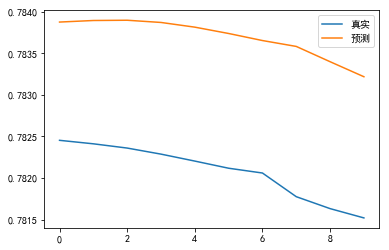

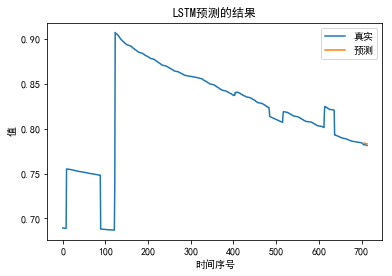

误差MSE： 2.6149262829089684e-06
误差RMSE： 0.0016170733696740443
误差MAE： 0.0016130790264618834
误差MAPE： 100.10312987022904


In [22]:
ratio = 20
epochs = 100 
sequence_length=10
model_layers = [1,50,100]

data_hit = pd.read_csv('hit_buquan_disk.csv')
Values_hit_new = Data_range(data_hit,3)
data_miss = pd.read_csv('miss_buquan_disk.csv')
Values_miss_new = Data_range(data_miss,3)
train_len = len(Values_miss_new)-20
test_len = 20
hit_rate = [b /(a+b) for a, b in zip(Values_miss_new,Values_hit_new)] 

train_data = hit_rate[:len(hit_rate)-ratio]
test_data = hit_rate[len(hit_rate)-ratio:]

model, test_y, predicted=run_network(train_data, test_data, epochs,sequence_length,model_layers)
test_y = test_y.reshape(1,-1).tolist()[0]
result(predicted,train_data,test_y)